# Première modélisation GPU - GPU Modelling for Dummies

Ce notebook illustre les principales étapes de mise en place d'une modélisation 2D via le code 'wolfgpu'.

Les étapes ne sont pas figées dans leur ordre d'apparition. Le modélisateur est libre de les réorganiser au mieux et selon ses besoins.

Ce notebook ne se veut pas une initiation à Python ou au Jupyter Notebook. Pour des informations générales, lisez la documentation abondante sur le net : 
  
  - https://jupyter.org/try-jupyter/notebooks/?path=notebooks/Intro.ipynb
  - https://www.python.org/about/gettingstarted/
  - https://codefinity.com/start/v8


## Importation des modules utiles

In [1]:
import _add_path

In [2]:
# Modules généraux
#  - gestion des fichiers/chemins d'accès
from os import getcwd
from os.path import join
from pathlib import Path
from tempfile import TemporaryDirectory

# - données géographiques
import geopandas as gpd
from osgeo import ogr, gdal, osr

# - données numériques
import numpy as np

# données images
from PIL import Image

#WOLF GPU
from wolfgpu.simple_simulation import BoundaryConditionsTypes, boundary_condition_2D, SimpleSimulation, Direction, TimeStepStrategy, InfiltrationInterpolation, Type_Param
from wolfgpu.glsimulation import SimulationDuration
from wolfgpu.SimulationRunner import SimulationRunner, estimate_best_window_size
from wolfgpu.loaders.simple_sim_loader import load_simple_sim_to_gpu
from wolfgpu.glsimulation import GLSimulation, ResultsStore

#WOLF HECE
from wolfhece.wolf_array import WolfArray, WOLF_ARRAY_FULL_SINGLE, WOLF_ARRAY_FULL_INTEGER, header_wolf
from wolfhece.Results2DGPU import wolfres2DGPU, views_2D
from wolfhece.wolf_vrt import *
from wolfhece.pywalous import *
from wolfhece.PyGui import MapManager
from wolfhece.PyWMS import getWalonmap, to_image

Répertoire de travail courant

In [3]:
print(getcwd())

d:\ProgrammationGitLab\HECEPython\docs\source\_static\examples\gpu\prepare_data


## Répertoires de simulation

In [4]:
# Utilisation de pathlib pour gérer les chemins d'accès -- plus souple que os.path
dir_sim    = Path(getcwd()).parent / "simulation"

# création du dossier de sortie, au besoin
dir_sim.mkdir(exist_ok=True)

# **Au besoin** - Création d'une interface graphique WOLF

**Remarque** 
 - L'ajout de l'interface WxPython au Jupyter Notebook peut parfois induire des freeze de l'affichage. 
 - Dans ce cas, il faut redémarrer l'application.

In [5]:
wx_exists=False # set True or False

# Ajoute la boucle d'événements WX dans l'interface Jupyter
# Doit être fait avant de créer l'objet WOLF
#  https://stackoverflow.com/questions/60419214/how-to-run-wx-python-in-jupyter-notebook
%gui wx

In [6]:
if wx_exists:
    # Création de l'objet WOLF
    mywolf=MapManager()
    # A partir de là, on peut utiliser mywolf pour créer des cartes, etc.
    # On peut accéder aux éléments graphiques via "mywolf.mapviewer" --> cf module PyDraw.py de wolfhece
    viewer=mywolf.mapviewer

## Création d'une matrice

Une matrice WOLF est **plus qu'une matrice Numpy**. 

Pour l'initialiser, il est préférable d'utiliser un objet 'header_wolf' qui contiendra les informations de dimensions et de position spatiale.

Par défaut :
 - le type de matrice est en virgule flottante simple précision (np.float32)
 - la valeur de remplissage est 1
 - la valeur nulle par défaut est 0

Il est possible de choisir le typage avec les constantes : WOLF_ARRAY_FULL_SINGLE, WOLF_ARRAY_FULL_INTEGER,...  --> voir "wolf_array.py"

En interne, la matrice est une matrice Numpy masquée (https://numpy.org/doc/stable/reference/maskedarray.generic.html) accessible via l'attribut "array".

Le stockage est :
 - de type 'Fortran' - column first
 - la forme est (nbx, nby), c'est-à-dire qu'il y a autant de lignes que de mailles souhaitées selon l'axe X et autant de colonnes que de mailles selon Y
 - les attributs "origx" et "origx" correspondent au coin inférieur gauche de la matrice
 - la maille [0,0] est donc associée à la coordonnée [origx + dx/2., origy + dy/2.]


In [8]:
myheader = header_wolf()

myheader.nbx = 100
myheader.nby = 200
myheader.dx = 1.
myheader.dy = 1.
myheader.origx = 10.
myheader.origy = 20.

myfirstarray = WolfArray(srcheader= myheader)

Vérification

In [9]:
print('min : ', myfirstarray.array.min())
print('max : ', myfirstarray.array.max())
print('shape : ', myfirstarray.array.shape)
print('coord [0,0] : ', myfirstarray.get_xy_from_ij(0,0))
print('\n')
print('Summary :\n')
print(myfirstarray)

min :  1.0
max :  1.0
shape :  (100, 200)
coord [0,0] :  (10.5, 20.5)


Summary :

Shape  : 100 x 200 
Resolution  : 1.0 x 1.0 
Spatial extent : 
   - Origin : (10.0 ; 20.0) 
   - End : (110.0 ; 220.0) 
   - Widht x Height : 100.0 x 200.0 
Null value :0.0



## Modification de valeurs de la matrice

Il s'agit de données Numpy **masquées**. Toutes les options sont possibles... pour autant que l'on ne remplace par le pointeur vers l'espace mémoire.

**"The sky is the limit"**

In [10]:
myfirstarray.array[0:100:2, 0:200:2] = 2.

## Ajout de la matrice à l'interface

In [11]:
if wx_exists:
    ret = viewer.add_object('array', newobj= myfirstarray, id = 'MyFirstArray')
    assert ret == 0, 'Error in adding object' # 0 is the return code for success

In [12]:
if wx_exists:
    viewer.Autoscale() # Redimensionne la fenêtre pour que tout soit visible

## Nouvelle modification de la matrice

In [13]:
# Nouvelle modification de l'array
myfirstarray.array[0, :] = 10.
myfirstarray.array[-1, :] = 10.
myfirstarray.array[:, 0] = 10.
myfirstarray.array[:, -1] = 10.

if wx_exists:
    myfirstarray.reset_plot() # Réinitialise le plot -- Nécessaire car l'affichage utilise des listes OpenGL afin d'accélérer l'affichage
    viewer.Paint() # Rafraîchit la fenêtre

## Récupération d'une image de la fenêtre graphique

Il est possible de récupérer un graphique Matplotlib avec le contenu de la fenêtre.

Retour de la fonction:
 - 1 figure
- 2 axes (axe 1 = figure 2D, axe 2 = légende)

Options :
 - coordonnées du centre [x,Y]
 - largeur - width [m]
 - hauteur - height [m]
 - titre - title (str)

 **Remarque** : Si le dessin obtenu est noir, réexécuter la commande car cela peut provenir d'une mauvaise mise à jour du buffer graphique OpenGL.

In [14]:
# dessin "interactif" - https://matplotlib.org/stable/api/widgets_api.html
%matplotlib widget
# dessin "fixe"
# %matplotlib inline

if wx_exists:
    fig, axes = viewer.get_mpl_plot(center = [55,115], width = 150, height = 300, title="Mon premier graphique", toshow = False)

    print('Nombre de figure : 1')
    print('Nopmbre de axes : ', len(axes))
else:
    print('No viewer -- create a GUI/viewer first')

No viewer -- create a GUI/viewer first


Changement de titre, ...

In [15]:
if wx_exists:
    axes[0].set_title('Mon nouveau titre')
    fig.canvas.draw()
    # La fenêtre est mise à jour avec le nouveau titre
else:
    print('No viewer -- create a GUI/viewer first')


No viewer -- create a GUI/viewer first


### Récupération uniquement du canvas OpenGL sous forme d'image

Pas d'axes, pas de légende... juste l'image

In [16]:
if wx_exists:
    img = viewer.get_canvas_as_impage()
    display(img)
else:
    print('No viewer -- create a GUI/viewer first')

No viewer -- create a GUI/viewer first


## Sauvegarde de la matrice

Il est souvent utile d'écrire un fichier avec les infoirmations numériques.

Plusieurs formats sont posibles (voir wolf_array.py) :
 - WOLF (extenion .bin)
 - GeoTif (extension .tif)
 - Numpy (extension .npy)
 - ...

 Le format WOLF sauvegarde en plus des informations binaires de la matrice un fichier "header" (.bin.txt) avec les informations de forme et de positionnement spatial.

 Le format GeoTif intègre toutes les informations dans un seul fichier. Il est en outre compressé.

 Le format Numpy stocke dans le fichier '.npy' la forme mais l'objet écrit le même fichier "header" que le format WOLF.

In [17]:
myfirstarray.write_all(dir_sim / "myfirstarray.bin")
myfirstarray.write_all(dir_sim / "myfirstarray.tif")
myfirstarray.write_all(dir_sim / "myfirstarray.npy")

## Relecture des données sauvegardées

Il est bien entendu possible de relire les données dans un nouvel objet.

In [18]:
read_bin = WolfArray(dir_sim / "myfirstarray.bin")
read_tif = WolfArray(dir_sim / "myfirstarray.tif")
read_npy = WolfArray(dir_sim / "myfirstarray.npy")

Vérification des données

In [19]:
print('Check if same parameters .bin : ', myfirstarray.is_like(read_bin))
print('Check if same parameters .tif : ', myfirstarray.is_like(read_tif))
print('Check if same parameters .npy : ', myfirstarray.is_like(read_npy))

print('Check if same data .bin : ', np.all(myfirstarray.array == read_bin.array))
print('Check if same data .tif : ', np.all(myfirstarray.array == read_tif.array))
print('Check if same data .npy : ', np.all(myfirstarray.array == read_npy.array))

Check if same parameters .bin :  True
Check if same parameters .tif :  True
Check if same parameters .npy :  True
Check if same data .bin :  True
Check if same data .tif :  True
Check if same data .npy :  True


# Si le problème est géolocalisé, récupération d'une image de fond de type WalonMap

Il est possible de récupérer une image depuis WalonMap (requiert une connexion internet rapide).

Pour cela, il faut lui fournir le type de donnée et les bornes.

Il est aussi possible de particulariser l'interface graphique et de récupérer l'image.

In [20]:
bounds = [[251000,253400],[135500,141300]] # Zone de Theux à Pepinster (Vesdre) [[Xmin,Xmax],[Ymin,Ymax]

# Récupération de l'image sous forme d'objet PILLOW (https://pillow.readthedocs.io/)
img = to_image(getWalonmap('IMAGERIE/ORTHO_2021', bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], tofile=False))
print(type(img))

<class 'PIL.PngImagePlugin.PngImageFile'>


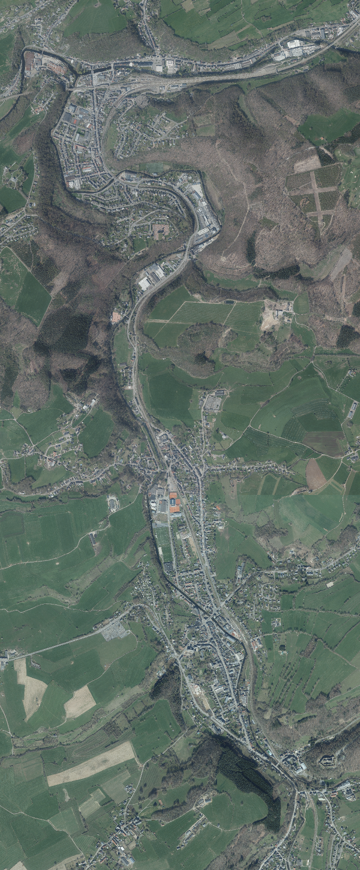

In [21]:
factor = 2
display(img.resize((img.size[0]//factor, img.size[1]//factor)))

# Simulation GPU - Préparation

Via un objet "SimpleSimulation"

Données nécessaires :
 - topo-bathymétrie
 - matrice de frottement - "n" Manning
 - matrice d'infiltration - zonage
 - conditions initiales (h, qx, qy)
 - conditions aux limites faibles - bords de maillage
 - matrice de masque de calcul (ici construit sur base du masque de topo-bathymétrie) -- 1 = à calculer ; 0 à ne pas calculer

## Topo-Bathymétrie

In [22]:
bathy = WolfArray(srcheader=myheader)

bathy.array[:, :] = 0. # On remplit l'array avec des 0
# on borde la matrice avec une valeur très grande qui servira de limite au problème
bathy.array[:3,:] = 99999.
bathy.array[-3:,:] = 99999.
bathy.array[:,:3] = 99999.
bathy.array[:,-3:] = 99999.

# On masque les valeurs à 99999.
# Ceci est nécessaire pour que la matrice nap soit correctement construite par la suite
bathy.nullvalue = 99999.
bathy.mask_data(99999.)

print(bathy)

Shape  : 100 x 200 
Resolution  : 1.0 x 1.0 
Spatial extent : 
   - Origin : (10.0 ; 20.0) 
   - End : (110.0 ; 220.0) 
   - Widht x Height : 100.0 x 200.0 
Null value :99999.0



## Frottement

In [23]:
manning = WolfArray(mold=bathy)
manning.array[:, :] = 0.03

print(manning)

Shape  : 100 x 200 
Resolution  : 1.0 x 1.0 
Spatial extent : 
   - Origin : (10.0 ; 20.0) 
   - End : (110.0 ; 220.0) 
   - Widht x Height : 100.0 x 200.0 
Null value :0.0



## Variables hydrauliques

In [24]:
# Création des matrices Wolf de hauteur d'eau et de débits spécifiques selon X et Y
h  = WolfArray(srcheader=bathy.get_header()) # récupération du header de la matrice de bathymétrie
qx = WolfArray(srcheader=bathy.get_header())
qy = WolfArray(srcheader=bathy.get_header())

# mise à 0. ou autre... en fonction des besoins
h.array[:,:] = 0.
qx.array[:,:] = 0.
qy.array[:,:] = 0.

## Infiltration

**Remarque** : cette matrice est en entier 32 bits (np.int32)

In [25]:
inf = WolfArray(whichtype=WOLF_ARRAY_FULL_INTEGER, srcheader=bathy.get_header())
inf.array[:,:] = 0
inf.array[3,3:-3] = 1 # imposition d'une zone d'infiltration selon Y, sur toute la largeur de la matrice à la première maille utile

print(inf)

Shape  : 100 x 200 
Resolution  : 1.0 x 1.0 
Spatial extent : 
   - Origin : (10.0 ; 20.0) 
   - End : (110.0 ; 220.0) 
   - Widht x Height : 100.0 x 200.0 
Null value :0.0



## Sauvegarde des matrices

Cette étape n'est **pas obligatoire** si les matrices sont générées à chaque exécution

In [26]:
h.write_all(join(dir_sim, 'simul.hbin'))
qx.write_all(join(dir_sim, 'simul.qxbin'))
qy.write_all(join(dir_sim, 'simul.qybin'))
inf.write_all(join(dir_sim, 'simul.inf'))
bathy.write_all(join(dir_sim, 'simul.top'))

## Création de l'instance SimpleSimulation

Etapes :
 1. instancier l'objet
 1. (optionel) ajouter un commentaire
 1. ajuster les paramètres
    - param_nx, param_ny : taille selon X et Y
    - param_dx, param_dy : résolution du problème selon X et Y
    - param_duration     : durée de modélisation (utilisation du type "SimulationDuration")
 1. création d'une matrice de masque (nap) -- type : np.uint8 -- toute valeur non nulle sera **calculable** si les conditions hydrauliques le permettent
 1. association des matrices **Numpy** -- seulement les données et pas l'objet "np.ma"

In [27]:
simul = SimpleSimulation()

simul.comment = 'Simulation for Dummies'

simul.param_nx, simul.param_ny = bathy.nbx, bathy.nby
simul.param_dx, simul.param_dy = bathy.dx, bathy.dy
simul.param_base_coord_ll_x, simul.param_base_coord_ll_y = bathy.origx, bathy.origy

simul.param_duration = SimulationDuration.from_seconds(int(1*3600)) # 1 heures

# masque de calcul
# --> Dépend ici du masquage des données bathymétriques
# --> Peut être construite totalement différemment au besoin
shape = (simul.param_nx, simul.param_ny)
simul.nap = np.zeros(shape, dtype=np.uint8) # initialisation à 0
simul.nap[:,:] = ~bathy.array.mask          # on met à 1 les mailles non masquées dans la topo-bathymétrie

# Les matrices sont partagées entre la classe SimpleSimulation et WolfArray
simul.h          = h.array.data
simul.qx         = qx.array.data
simul.qy         = qy.array.data
simul.bathymetry = bathy.array.data
simul.manning    = manning.array.data
simul.infiltration_zones = inf.array.data

On s'attend à ce que la fin du domaine soit entre les mailles 96 et 97 puisque 3 mailles de pourtour ont été cachées

--> Check

In [28]:
print(simul.nap[96,4])
print(simul.nap[97,4])

assert simul.nap[96,4] == 1 and simul.nap[97,4] == 0, 'Error in nap'

1
0


### Imposition des conditions aux limites

Type de conditions aux limites (cf Enum "BoundaryConditionsTypes"):
 - H     : Altitude de surface libre [$m$]
 - QX    : débit selon X [$m^3/s$]
 - QY    : débit selon Y [$m^3/s$]
 - NONE  : aucune
 - FROUDE_NORMAL : Froude normal au bord - en réalité, altitude calculée sur base du débit normal et valeur souhaitée du Froude

Pour imposer une CL sur un bord de maille, il faut:
 - indiquer les indices (i,j) de la maille concernée
 - fournir le type "bc_type" et la valeur "bc_value"
 - indiquer sur quel bord travailler (cf Enum "Direction")
    - LEFT
    - BOTTOM
    - X
    - Y

Etant donné que l'on ne peut choisir qu'entre LEFT et BOTTOM, cela signifie qu'il faut donner les 
indices de la maille située à droite/haut du bord concerné, 
même si cette maille ne fait pas partie du domaine de calcul.

La **convention d'indicage** est celle qui vaut dans le matrices fournies, à savoir i varie selon X et j varie selon Y avec l'élément [1,1] comme premier élément en bas à gauche.

**Remarque** :
 - Les indices des bords CL sont "1-based" pour des raisons de compatibilité avec d'autres versions de WOLF.
 - Pour rappel, Python est 0-based
 - il est également possible de récupérer les lignes de script **générées par l'interface graphique** et les coller ici


In [45]:
# ici, tous les bords les plus à droite impose un Froude normal de 0.3
# sim.clear_boundary_conditions()
# for j in range(3,198):
#     sim.add_boundary_condition(i=98, j=j, bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=.3, border=Direction.LEFT)

Via le GUI wolf :
 - ajouter la matrice topo-bathymétrique (adapter éventuellement la NullValue à 99999. pour obtenir le bon domaine)
 - créer un gestionnaire de CL version GPU (File/Create.../Create BC manager Wolf2D...  -> GPU)
 - sélectionner les bords et choisir le type de CL
 - copier les lignes de scripts (bouton "Copy script to clipboard")

In [29]:
simul.clear_boundary_conditions()

simul.add_boundary_condition(i=98, j=4,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=5,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=6,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=7,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=8,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=9,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=10,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=11,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=12,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=13,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=14,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=15,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=16,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=17,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=18,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=19,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=20,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=21,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=22,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=23,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=24,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=25,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=26,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=27,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=28,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=29,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=30,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=31,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=32,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=33,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=34,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=35,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=36,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=37,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=38,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=39,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=40,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=41,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=42,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=43,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=44,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=45,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=46,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=47,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=48,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=49,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=50,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=51,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=52,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=53,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=54,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=55,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=56,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=57,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=58,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=59,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=60,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=61,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=62,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=63,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=64,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=65,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=66,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=67,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=68,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=69,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=70,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=71,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=72,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=73,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=74,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=75,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=76,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=77,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=78,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=79,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=80,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=81,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=82,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=83,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=84,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=85,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=86,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=87,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=88,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=89,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=90,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=91,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=92,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=93,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=94,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=95,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=96,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=97,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=98,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=99,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=100,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=101,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=102,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=103,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=104,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=105,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=106,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=107,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=108,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=109,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=110,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=111,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=112,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=113,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=114,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=115,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=116,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=117,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=118,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=119,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=120,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=121,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=122,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=123,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=124,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=125,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=126,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=127,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=128,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=129,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=130,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=131,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=132,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=133,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=134,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=135,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=136,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=137,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=138,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=139,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=140,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=141,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=142,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=143,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=144,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=145,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=146,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=147,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=148,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=149,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=150,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=151,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=152,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=153,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=154,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=155,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=156,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=157,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=158,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=159,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=160,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=161,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=162,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=163,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=164,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=165,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=166,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=167,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=168,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=169,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=170,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=171,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=172,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=173,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=174,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=175,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=176,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=177,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=178,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=179,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=180,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=181,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=182,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=183,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=184,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=185,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=186,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=187,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=188,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=189,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=190,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=191,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=192,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=193,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=194,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=195,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=196,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)
simul.add_boundary_condition(i=98, j=197,bc_type=BoundaryConditionsTypes.FROUDE_NORMAL, bc_value=0.3, border=Direction.LEFT)


## Ajout d'un hydrogramme pour la/les zone(s) d'infiltration

Il faut utilise la routine "add_infiltration" qui attend un temps en secondes et une liste Python avec autant de valeur que de zones (ici 1 seule).

In [30]:
simul.clear_infiltration_chronology() # par sécurité, on peut commencer par effacer les chronologies d'infiltration
simul.add_infiltration(0., [1.])
simul.add_infiltration(3600., [1.2])
simul.add_infiltration(10.*3600., [1.5])

Vérification

In [31]:
simul._infiltrations_chronology

[[0.0, [1.0]], [3600.0, [1.2]], [36000.0, [1.5]]]

Graphique simple mais particularisable...

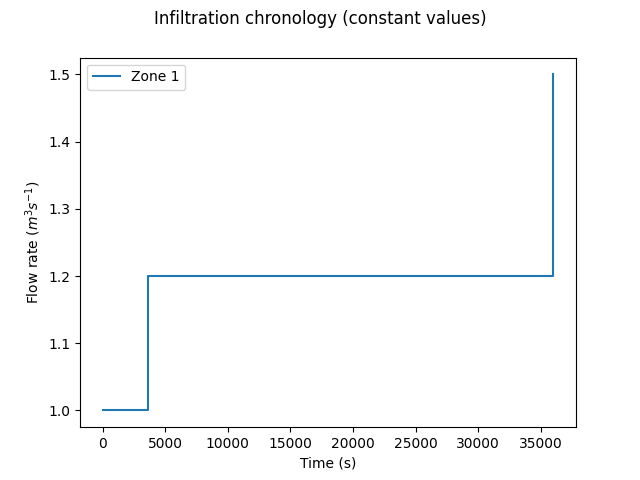

In [32]:
fig_inf, ax_inf = simul.plot_infiltration(toshow=False)

## Paramètres numériques

- Nombre de Courant (le code itère temporellement de façon explicite selon un schéma Runge-Kutta, il est donc soumis à une conditions de stabilité numérique via le nombre de Courant)
- des oscillations dans les résultats, une apparition de "damier" sont le signe d'instabilités. Il faut alors réduire quelque peu le NC.
- période de raportage via le type "SimulationDuration" (en secondes, en nombre d'itérations)

In [33]:
simul.param_courant = .4
simul.param_report_period = SimulationDuration.from_seconds(100.)

## Vérification d'erreurs éventuelles de paramétrage

Tout n'est pas testé mais cela aide fortement avec les erreurs fréquentes.

In [35]:
ret = simul.check_errors()
print(ret)

None


## Sauvegarde de la simulation au format GPU

Une simulation au format "SimpleSimulation" stocke ses données de base et ses paramètres dans un format Numpy et JSON.

**Remarques:**
 - Matrice au format Numpy - orientées coordonnées cartésiennes (X selon les lignes et Y selon les colonnes)
 - JSON : fichier texte avec balises - https://en.wikipedia.org/wiki/JSON#:~:text=JSON%20(JavaScript%20Object%20Notation%2C%20pronounced,(or%20other%20serializable%20values)
 - il faut fournir à la méthode 'save' un chemin d'accès de type 'Path'
 - si le répertoire n'existe pas, il est créé

In [36]:
dir_sim_gpu = Path(dir_sim) / 'gpu'
simul.save(dir_sim_gpu)

# Simulation GPU - Exécution

Il est préférable d'exécuter le calcul via une ligne de commande en appelant l'exécutable "wolfgpu".

Exemple : "wolfgpu --quickrun ." ou "wolfgpu --quickrun FullPathtoSimDir"

Cette manière de procéder permet d'exploiter toute la richesse du paramétrage de ligne de commande.

In [38]:
assert (dir_sim_gpu / 'simul_gpu_results').exists(), 'You must run the simulation before running this cell'

# Simulation GPU - Résultats

Le code GPU va écrire des résultats sur base de la fréquence de reporting souhaitée.

Les résultats sont stockés dans le sous-répertoire "simul_gpu_results" du répertoire de modélisation.

Pour accéder aux résultats, il est possible :
 - d'ajouter une visualisation de résultats dans le GUI "File/Add.../Add Wolf2D GPU results..."
 - d'utiliser un objet:
    - "ResultsStore" du paquet "wolfgpu"
    - "wolfres2DGPU" du paquet "wolfhece"

Le "ResultsStore" donnera accès aux variables hydrodynamiques de base sous forme de tableau Numpy. 

**Remarque** : Le tableau Numpy sera transposé par rapport aux autres matrices utilisées; la convention employée en interne du code GPU étant différente. Il est donc plus prudent d'employer "wolfres2DGPU" en cas de doute.

Le "wolfres2DGPU" fournira plus de fonctionnalités dont la combinaison en variables plus complexes (Froude, Shields...)


## Emploi du ResultsStore

**Remarque** : Les éléments rendus étant des matrrices Numpy, il n'y a pas de valeur nulle définie. Il est attendu que les inconnues hydrodynamiques soient nulles à tout le moins en dehors du domaine calculé.

In [39]:
store = ResultsStore(dir_sim_gpu / 'simul_gpu_results', mode='r')

In [40]:
print(store.get_named_result.__doc__)

 Looks for result by names. Supported names are: t, last_delta_t,
            step_num, h, qx, qy.
        


In [41]:
print('Nb results : ', store.nb_results)
print('Il est donc possible de récupérer les résultats de la simulation entre 1 et {}'.format(store.nb_results))

Nb results :  36
Il est donc possible de récupérer les résultats de la simulation entre 1 et 36


In [42]:
h_store = store.get_named_result('h', 1)
print('Type : ', type(h_store))
print('Shape', h_store.shape)

Type :  <class 'numpy.ndarray'>
Shape (200, 100)


In [43]:
t,dt,n_iter_dry_up_euler, n_iter_dry_up_rk, h_store,qx_store,qy_store = store.get_last_result()

## Emploi de wolfres2DGPU

La classe "wolfres2DGPU" hérite de "Wolfresults_2D" qui permet de lire les résultats du code WOLF Fortran.

Les traitements seront dès lors identiques en version Fortran ou GPU.

Ces objets sont adaptés aux résultats multiblocs --> chaque bloc est contenu dans un dictionnaire interne. Le code GPU n'a pas actuellement de capacité multiblocs. Les résultats sont dès lors dans le bloc [0] accessible via "res2d[0]".

Les valeurs obtenues dépendent de l'état courant de l'objet via "set_currentview" et un choix parmi l'Enum "Views2D"

 - WATERDEPTH = _('Water depth [m]')
 - WATERLEVEL = _('Water level [m]')
 - TOPOGRAPHY = _('Bottom level [m]')
 - QX = _('Discharge X [m2s-1]')
 - QY = _('Discharge Y [m2s-1]')
 - QNORM = _('Discharge norm [m2s-1]')
 - UX  =_('Velocity X [ms-1]')
 - UY = _('Velocity Y [ms-1]')
 - UNORM = _('Velocity norm [ms-1]')
 - HEAD = _('Head [m]')
 - FROUDE = _('Froude [-]')
 - KINETIC_ENERGY = _('Kinetic energy k')
 - EPSILON = _('Rate of dissipation e')
 - TURB_VISC_2D = _('Turbulent viscosity 2D')
 - TURB_VISC_3D = _('Turbulent viscosity 3D')
 - VECTOR_FIELD_Q = _('Discharge vector field')
 - VECTOR_FIELD_U = _('Velocity vector field')
 - SHIELDS_NUMBER = _('Shields number - Manning-Strickler')
 - CRITICAL_DIAMETER_SHIELDS = _('Critical grain diameter - Shields')
 - CRITICAL_DIAMETER_IZBACH = _('Critical grain diameter - Izbach')
 - CRITICAL_DIAMETER_SUSPENSION_50 = _('Critical grain diameter - Suspension 50%')
 - CRITICAL_DIAMETER_SUSPENSION_100 = _('Critical grain diameter - Suspension 100%')
 - QNORM_FIELD = _('Q norm + Field')
 - UNORM_FIELD = _('U norm + Field')
 - WL_Q = _('WL + Q')
 - WD_Q = _('WD + Q')
 - WL_U = _('WL + U')
 - WD_U = _('WD + U')
 - T_WL_Q = _('Top + WL + Q')
 - T_WD_Q = _('Top + WD + Q')
 - T_WD_U = _('Top + WD + U')


**Remarque** : La valeur nulle d'un objet "wolfres2DGPU" sera par défaut 99999. --> valeur utilisée pour la topo-bathymétrie des valeurs non-calculées.

In [44]:
res2d = wolfres2DGPU(dir_sim_gpu, plotted=False)

In [45]:
print('Nb results : ', res2d.get_nbresults())
print('Il est donc possible de récupérer les résultats de la simulation entre 1 et {}'.format(res2d.get_nbresults()))

Nb results :  36
Il est donc possible de récupérer les résultats de la simulation entre 1 et 36


In [46]:
res2d.read_oneresult(-1) # -1 pour le dernier résultat

In [47]:
res2d.set_currentview(views_2D.WATERDEPTH)
h_res = res2d[0]
res2d.set_currentview(views_2D.QX)
qx_res = res2d[0]
res2d.set_currentview(views_2D.QY)
qy_res = res2d[0]

In [48]:
print('Max : ', h_res.array.max(), qx_res.array.max(), qy_res.array.max())
print('Min : ', h_res.array.min(), qx_res.array.min(), qy_res.array.min())

Max :  0.07136334 0.006170503 --
Min :  0.03207793 0.005152561 --


## Combinaison de résultats

Les objets WolfArray surchargent les opérateurs mathématiques. Il est donc possible d'écrire facilement des variables secondaires comme la vitesse.

N.B. : ces fonctionnalités sont bien entendu utilisées en interne.

In [49]:
u = (qx_res**2. + qy_res**2.)**.5 / h_res

print('Type : ', type(u))
print('Shape :', u.array.shape)

Type :  <class 'wolfhece.wolf_array.WolfArray'>
Shape : (100, 200)


## Comparaison des deux options d'accès aux résultats

**Remarque** Attention aux remarques sur les valeurs nulles ci-dessus.

In [50]:

h_res.nullvalue = 0
h_res.set_nullvalue_in_mask()
qx_res.nullvalue = 0
qx_res.set_nullvalue_in_mask()
qy_res.nullvalue = 0
qy_res.set_nullvalue_in_mask()

print('Type : ',type(h_res))
print('Type : ',type(h_res.array))
print('Type : ',type(h_res.array.data))

print('Shape', h_res.array.data.shape)

Type :  <class 'wolfhece.wolf_array.WolfArray'>
Type :  <class 'numpy.ma.core.MaskedArray'>
Type :  <class 'numpy.ndarray'>
Shape (100, 200)


In [51]:
assert(np.all(h_res.array.data == h_store.T))
assert(np.all(qx_res.array.data == qx_store.T))
assert(np.all(qy_res.array.data == qy_store.T))

print('Tout va bien !')

Tout va bien !


# Votre première modélisation via Wolf GPU est achevée !!

Il ne reste plus qu'à... travailler !